# Atmospheric transmittance at u-band

2022/07/03 H. Akitaya (PERC/CIT)

In [1]:
import numpy as np
from scipy import interpolate
from scipy import integrate

Filter resonse curve.

In [2]:
class FilterResponceCurve(object):
    def __init__(self, wls=None, trs=None):
        self.wls = wls
        self.trs = trs
        self.wls_nrm = None
        self.trs_nrm = None
        self.wl_min = None  # Min wavelength.
        self.wl_max = None  # Max wavelength.
        print(type(self.trs))
        
    def make_normalized_curve(self):
        self.wl_min = np.min(self.wls)
        self.wl_max = np.max(self.wls)
        filter_curve = interpolate.interp1d(self.wls, self.trs)
        filter_integ = integrate.quad(filter_curve, self.wl_min, self.wl_max)
        # print(filter_integ)
        # print(type(self.trs), self.trs)
        self.wls_nrm = self.wls
        try:
            self.trs_nrm = self.trs / float(filter_integ[0])
        except ValueError:
            self.trs_num = self.trs * 0.0
            
    def get_normalized_curve(self):
        return self.wls_nrm, self.trs_nrm
    
    def get_normalized_curve_wls(self):
        return self.wls_nrm
    
    def get_normalized_curve_trs(self):
        return self.trs_nrm
    
    def interpolated_function(self, wl):
        func = interpolate.interp1d(self.wls_nrm, self.trs_nrm)
        return func(wl)

Read SDSS filter curve.

In [3]:
from urllib.request import urlopen

In [4]:
wls= []
trs = []

In [5]:
with urlopen("http://hikari.astron.s.u-tokyo.ac.jp/work/SDSS/filters/57mm/9808UB1") as f:
    for line in f:
        decoded_line = line.decode("utf-8")
        wls.append(float(decoded_line.split()[0])/10.0)
        trs.append(float(decoded_line.split()[1]))
wls = np.array(wls)
trs = np.array(trs)

In [6]:
len(wls), len(trs)

(801, 801)

In [7]:
fltr_sdss_u = FilterResponceCurve(wls, trs)

<class 'numpy.ndarray'>


In [8]:
fltr_sdss_u.make_normalized_curve()

/tmp/ipykernel_56386/1567011875.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  filter_integ = integrate.quad(filter_curve, self.wl_min, self.wl_max)


In [9]:
fltr_u_nrm = fltr_sdss_u.get_normalized_curve()

In [10]:
a = fltr_sdss_u.interpolated_function(350.0)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
plt.xlim(fltr_sdss_u.wl_min, fltr_sdss_u.wl_max)
plt.plot(fltr_sdss_u.wls_nrm, fltr_sdss_u.trs_nrm)

Integration test.

In [13]:
temp_curve = interpolate.interp1d(fltr_sdss_u.wls_nrm, fltr_sdss_u.trs_nrm)
integrate.quad(temp_curve, fltr_sdss_u.wl_min, fltr_sdss_u.wl_max)

/tmp/ipykernel_56386/2306273230.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(temp_curve, fltr_sdss_u.wl_min, fltr_sdss_u.wl_max)


(0.9999999999999997, 0.0019895497340426394)

Lowtran wrapper.

In [14]:
import lowtran
from astropy.table import Table

class AtmModel(object):
    
    MODEL_NAMES = {
        2: 'Midlatitude Summer',
        3: 'Midlatitude Winter',
        4: 'Subarctic Summer',
        5: 'Subarctic Winter',
        6: '1976 US Standard',
    }

    PARAMS_DEFAULT = {
        'model': 3,  # Midlatitude winter.
        'h1': 0.0,  # Altitude of the site. [km] 
        'angle': 0.0,  # Zentih angle. [deg]
        'wlshort': 300.0,  # Shortest wavelength. [nm]
        'wllong': 1100.0,  # Longest wavelength. [nm]
        'wlstep': 10.0,  # Wavelength step. [nm]
    }

    def __init__(self, params=PARAMS_DEFAULT):
        self.params = params
        self.tr = None
        
    def make_transmittance_model(self):
        """ Make transmittance model curve from LOWTRAN7 MODEL.
        """
        self.tr = lowtran.transmittance(self.params)
        wls = self.tr['wavelength_nm'].to_numpy()
        trs = self.tr['transmission'].to_numpy()[0].T[0]
        self.tbl = Table([wls, trs], names=('wavelength_nm', 'transmission'), meta=self.params)
        
    def read_transmittance_model(self, fn, wl_conversion_factor=1.0, unit_mag=False, unit_percent=False):
        """ Read transmittance model from a file.
        """
        try:
            self.tbl = Table.read(fn, format='ascii')
        except OSError:
            sys.stderr.write('File {} read error.'.format(fn))
            return
        self.tbl.rename_columns(self.tbl.colnames, ['wavelength_nm', 'transmission'])
        wls_tmp = self.tbl['wavelength_nm'].astype(float)
        self.tbl.replace_column('wavelength_nm', wls_tmp)
        self.tbl['wavelength_nm'] *= wl_conversion_factor
        if unit_percent:
            self.tbl['transmission'] *= 0.01
        if unit_mag:
            self.tbl['transmission'] = 10.0**(self.tbl['transmission']/(-2.5))
        
        
    def interpolated_tranmittance(self, wl):
        func = interpolate.interp1d(self.tbl['wavelength_nm'], self.tbl['transmission'])
        return func(wl)
    
    def get_filter_transmittance(self, filter_function):
        def multiplied_function(wl):
            return filter_function(wl) * self.interpolated_tranmittance(wl)
        integ = integrate.quad(multiplied_function, 320, 400)
        return integ

In [15]:
atm_model = AtmModel()

In [16]:
atm_model.read_transmittance_model('kpnoextinct.dat', wl_conversion_factor=0.1, unit_mag=True)

In [17]:
atm_model.tbl.colnames

['wavelength_nm', 'transmission']

In [18]:
atm_model.tbl

<Table length=82>
  wavelength_nm        transmission   
     float64             float64      
------------------ -------------------
             320.0 0.39192232245497677
             325.0  0.4442219354710552
             330.0 0.48439538854784026
             335.0  0.5100350239594466
             340.0  0.5330893422367015
             345.0  0.5551367774352113
             350.0  0.5754399373371569
             357.1  0.5992389025834781
             363.6  0.6205831792990618
370.40000000000003  0.6403243244689469
               ...                 ...
             791.0  0.9514807363517586
             800.0   0.953235043920515
             809.0  0.9541134102819798
             821.0   0.954992586021436
             826.0  0.9558725718846913
             837.0  0.9567533686182412
 870.8000000000001  0.9727472237769651
             983.2  0.9523574861919197
1025.6000000000001  0.9790390174480513
            1040.0   0.978137704322986

In [19]:
# help(FileExistsError)

In [20]:
atm_model.make_transmittance_model()

In [21]:
atm_model.tbl.show_in_notebook()

In [22]:
atm_model.interpolated_tranmittance(350.0)

array(0.5315255)

In [23]:
type(atm_model)

__main__.AtmModel

In [24]:
atm_model.get_filter_transmittance(fltr_sdss_u.interpolated_function)

/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


(0.49335786553913563, 0.00011139334539783663)

In [25]:
class ObsSite(object):
    def __init__(self, name, height, tr, band='', tr_unit_mag=False, info=''):
        self.name = name  # Site name.
        self.height = height  # Site altitude (km).
        self.tr = tr if tr_unit_mag is False else 10**(tr/(-2.5))
        self.band = band
        self.info = info  # Information text.

In [26]:
flag =True

In [27]:
tr_test = 0.1

In [28]:
tr_test2 = tr_test if flag is False else 10**(tr_test/(-2.5))

In [29]:
tr_test2

0.9120108393559098

In [30]:
sites = {}
atm_models = {}

In [31]:
sites['Tibet'] = ObsSite('Tibet', 5.130, 0.366, band='u', tr_unit_mag=True, info='Liu+2022')

In [32]:
atm_models['Mauna Kea'] = AtmModel()
atm_models['Mauna Kea'].read_transmittance_model('mkoextinct.dat', wl_conversion_factor=0.1, unit_mag=True)

In [33]:
atm_models['Mauna Kea'].tbl.show_in_notebook()

In [34]:
atm_models['Mauna Kea'].get_filter_transmittance(fltr_sdss_u.interpolated_function)

/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


(0.62377035170609, 5.9246034100419525e-05)

In [35]:
sites['Mauna Kea'] = ObsSite('Mauna Kea', 4.213, 
                             atm_models['Mauna Kea'].get_filter_transmittance(fltr_sdss_u.interpolated_function)[0],
                             band='u', tr_unit_mag=True, info='IRAF Gemini tools')

/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


In [36]:
sites['Mauna Kea'].tr

0.5629785644794436

In [37]:
sites['Mauna Kea'].__dict__

{'name': 'Mauna Kea',
 'height': 4.213,
 'tr': 0.5629785644794436,
 'band': 'u',
 'info': 'IRAF Gemini tools'}

In [38]:
atm_models['KPNO'] = AtmModel()
atm_models['KPNO'].read_transmittance_model('kpnoextinct.dat', wl_conversion_factor=0.1, unit_mag=True)

In [39]:
sites['KPNO'] = ObsSite('KPNO', 2.096, 
                        atm_models['KPNO'].get_filter_transmittance(fltr_sdss_u.interpolated_function)[0],
                        band='u', tr_unit_mag=True, info='IRAF database')

/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


In [40]:
sites['KPNO'].__dict__

{'name': 'KPNO',
 'height': 2.096,
 'tr': 0.6119457108042623,
 'band': 'u',
 'info': 'IRAF database'}

In [41]:
atm_models['CTIO'] = AtmModel()
atm_models['CTIO'].read_transmittance_model('ctioextinct.dat', wl_conversion_factor=0.1, unit_mag=True)
sites['CTIO'] = ObsSite('CTIO', 2.207, 
                        atm_models['CTIO'].get_filter_transmittance(fltr_sdss_u.interpolated_function)[0],
                        band='u', tr_unit_mag=True, info='IRAF database')

/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


In [42]:
sites['CTIO'].__dict__

{'name': 'CTIO',
 'height': 2.207,
 'tr': 0.6174351634659366,
 'band': 'u',
 'info': 'IRAF database'}

In [43]:
sites['OAO'] = ObsSite('OAO', 0.38,
                       np.average(np.array([1.175, 1.25, 1.5])),
                       band='360nm', tr_unit_mag=True, info='Yoshida1993')

In [44]:
lowtran_tr_ext = {}

In [45]:
heights = np.arange(0, 6.0, 0.1)
for model_n in AtmModel.MODEL_NAMES.keys():
    trs = []
    print('#model {}'.format(model_n))
    mdl = AtmModel()
    mdl.params['model'] = model_n
    for height in heights:
        mdl.params['h1'] = height
        mdl.make_transmittance_model()
        trs.append(mdl.get_filter_transmittance(fltr_sdss_u.interpolated_function)[0])
    lowtran_tr_ext[model_n] = np.array(trs)

#model 2


/tmp/ipykernel_56386/2302118099.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(multiplied_function, 320, 400)


#model 3
#model 4
#model 5
#model 6


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

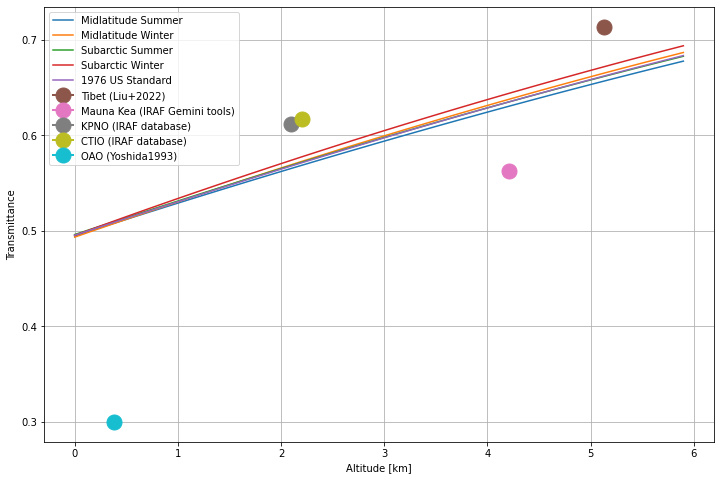

In [47]:
fig, (ax) = plt.subplots(1,1, figsize=(12,8))
ax.grid()
ax.set_xlabel('Altitude [km]')
ax.set_ylabel('Transmittance')
for model_n in AtmModel.MODEL_NAMES.keys():
    ax.plot(heights, lowtran_tr_ext[model_n], label=AtmModel.MODEL_NAMES[model_n])
for site in sites.keys():
    ax.plot(sites[site].height, sites[site].tr, label=sites[site].name + ' (' + 
            sites[site].info + ')', marker='o', lw=2, markersize='15')
ax.legend()

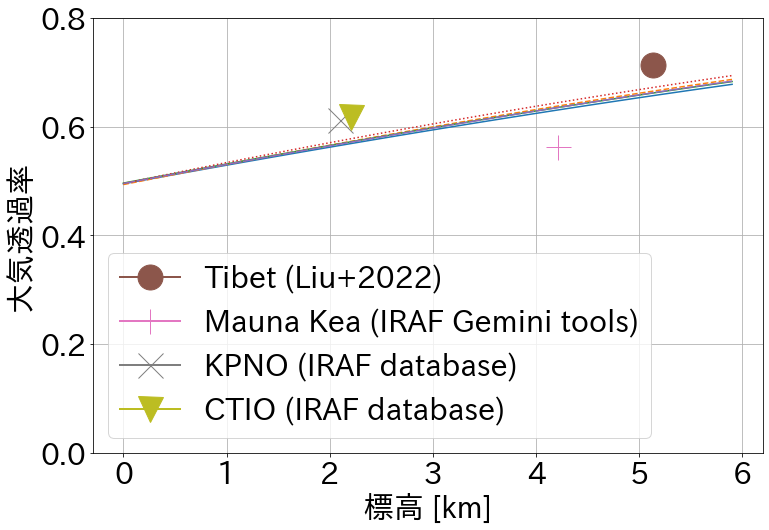

In [57]:
import japanize_matplotlib
plt.rcParams["font.size"] = 30
fig, (ax) = plt.subplots(1,1, figsize=(12,8))
ax.grid()
ax.set_ylim([0.0, 0.8])
ax.set_xlabel('標高 [km]')
ax.set_ylabel('大気透過率')
markers = ['o', '+', 'x', 'v']
linestyles = ['-', '--', '-', ':', (0,(8,1))]
i=0
for model_n in AtmModel.MODEL_NAMES.keys():
#    ax.plot(heights, lowtran_tr_ext[model_n], label=AtmModel.MODEL_NAMES[model_n], linestyle=linestyles[i])
    ax.plot(heights, lowtran_tr_ext[model_n], linestyle=linestyles[i])
    i+=1
i=0
for site in sites.keys():
    if site == 'OAO': continue
    ax.plot(sites[site].height, sites[site].tr, label=sites[site].name + ' (' + 
            sites[site].info + ')', marker=markers[i], lw=2, markersize='25')
    i += 1
ax.legend()
plt.savefig('uband_height.png')